# Graph Representation Learning Take-Home Exam

## Question 3

We investigate the effect of a novel drop-out approach to alleviate over-squashing in Graph Attention Networks by leveraging the attention weights, and test the new approach on synthetic and real-world datasets.

While Graph Attention Networks are designed to learn which nodes are relevant to which nodes' representations, they still suffer from over-squashing like other networks (Figure 3, \cite{alon_bottleneck_2021}).

Instead of using dropout for improving generalization capability of the network, we use it to keep the entropy at the different layers constant. To not lose information on important nodes, we leverage the learned attention weights at every update step to update node-specific drop-out probabilities, and ignore the least important nodes with high probability.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.utils.convert import from_scipy_sparse_matrix, to_scipy_sparse_matrix

### Graph Attention Dropout Module

In [3]:
def attention_dropout(p: float, edge_attr, training: bool = True) -> torch.Tensor:
    r"""
Randomly drop nodes, proportionate to unimportance using current attention weights. Note: Certain elements of 
original dropout function F.dropout are copied.
    
Args:
    p: average probability of an element to be zeroed.
    attention: current attention weights
    training: apply dropout if is ``True``. Default: ``True``

Returns:
    original input masked by dropped out nodes
    """
#     if not training:
#         return edge_attr

    assert p <= 1 and p >= 0, f"dropout probability has to be between 0 and 1, but got, {p}"

    if p == 1:
        return torch.zeros_like(edge_attr)

    if p == 0:
        return edge_attr
    
    # for each node, we rescale the attentions to neighboring nodes to [0,1]
    preserve_probability = edge_attr / edge_attr.sum()
#     print(preserve_probability.mean(), preserve_probability)
    
    # scale preservation probability such that on average, nodes are dropped out with prob p
    preserve_probability = preserve_probability * (1-p) / preserve_probability.mean()

    dropout_mask = torch.rand_like(preserve_probability) < preserve_probability    

    return edge_attr * dropout_mask

### GATConv Module

Modified from PyTorch Geometric, https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gat_conv.html

In [5]:
from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import NoneType  # noqa
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros


class GAT_ADConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    If the graph has multi-dimensional edge features :math:`\mathbf{e}_{i,j}`,
    the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j
        \, \Vert \, \mathbf{\Theta}_{e} \mathbf{e}_{i,j}]\right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k
        \, \Vert \, \mathbf{\Theta}_{e} \mathbf{e}_{i,k}]\right)\right)}.

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). (default: :obj:`None`)
        fill_value (float or Tensor or str, optional): The way to generate
            edge features of self-loops (in case :obj:`edge_dim != None`).
            If given as :obj:`float` or :class:`torch.Tensor`, edge features of
            self-loops will be directly given by :obj:`fill_value`.
            If given as :obj:`str`, edge features of self-loops are computed by
            aggregating all features of edges that point to the specific node,
            according to a reduce operation. (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"min"`, :obj:`"max"`, :obj:`"mul"`). (default: :obj:`"mean"`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V_s}|, F_{s}), (|\mathcal{V_t}|, F_{t}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`,
          edge features :math:`(|\mathcal{E}|, D)` *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, H * F_{out})` or
          :math:`((|\mathcal{V}_t|, H * F_{out})` if bipartite.
          If :obj:`return_attention_weights=True`, then
          :math:`((|\mathcal{V}|, H * F_{out}),
          ((2, |\mathcal{E}|), (|\mathcal{E}|, H)))`
          or :math:`((|\mathcal{V_t}|, H * F_{out}), ((2, |\mathcal{E}|),
          (|\mathcal{E}|, H)))` if bipartite
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        attn_dropout: float = 0.5,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value
        self.attention_dropout = attn_dropout

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        # NOTE: attention weights will be returned whenever
        # `return_attention_weights` is set to a value, regardless of its
        # actual value (might be `True` or `False`). This is a current somewhat
        # hacky workaround to allow for TorchScript support via the
        # `torch.jit._overload` decorator, as we can only change the output
        # arguments conditioned on type (`None` or `bool`), not based on its
        # actual value.

        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = (alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # edge_updater_type: (alpha: OptPairTensor, edge_attr: OptTensor)
        alpha = self.edge_updater(edge_index, alpha=alpha, edge_attr=edge_attr)
        
        ## ADD DROPOUT HERE!
        alpha = attention_dropout(self.attention_dropout, alpha, training=self.training)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out


    def edge_update(self, alpha_j: Tensor, alpha_i: OptTensor,
                    edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None and self.lin_edge is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha


    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return alpha.unsqueeze(-1) * x_j

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

### Building the Model

In [6]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv
from tqdm.notebook import tqdm

In [7]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [10]:
class GAT_AD(nn.Module):
    def __init__(
              self,
              input_dim: int,
              hid_dim: int,
              n_classes: int,
              n_layers: int,
              dropout_ratio: float = 0,
              attention_dropout: float = 0.5):
        super(GAT_AD, self).__init__()
        """
        Args:
          input_dim: input feature dimension
          hid_dim: hidden feature dimension
          n_classes: number of target classes
          n_layers: number of layers
          dropout_ratio: dropout_ratio
          attention_dropout: 
        """
        ## ------ Begin Solution ------ ##
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_classes = n_classes
        self.dropout_ratio = dropout_ratio
        self.attention_dropout = attention_dropout
        
        layers = []
        dims = [input_dim] + [hid_dim for _ in range(n_layers)]
        for i in range(n_layers):
            layers.append(GAT_ADConv(dims[i], dims[i+1], dropout=dropout_ratio, attn_dropout=self.attention_dropout))
            
        self.mlp_layer = nn.Linear(dims[-1], n_classes)
        self.gcn_layers = nn.ModuleList(layers)
        self.param_init()
        ## ------ End Solution ------ ##

    def forward(self, X, A) -> torch.Tensor:
        ## ------ Begin Solution ------ ##
#         print(torch.unique(A[0], return_counts=True)[1].float().mean())
        X = self.generate_node_embeddings(X, A)
        X = F.log_softmax(self.mlp_layer(X),dim=0)
        return X
        ## ------ End Solution ------ ##

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        ## ------ Begin Solution ------ ##
        for i, layer in enumerate(self.gcn_layers):
            X = layer(X, A)
            if i < len(self.gcn_layers)-1: 
                X = F.relu(X)
        return X
        ## ------ End Solution ------ ##

    def param_init(self):
        ## ------ Begin Solution ------ ##
        for layer in self.gcn_layers:
            layer.reset_parameters()
        self.mlp_layer.reset_parameters()
        ## ------ End Solution ------ ##

In [11]:
def evaluate(
    model,
    data,
    mask
):
    ## ------ Begin Solution ------ ##
    model.eval()
    y_pred = model(data.x, data.edge_index)
    accuracy = (torch.sum(torch.argmax(y_pred[mask], dim=1) == data.y[mask]) / torch.sum(mask)).cpu()
    return accuracy
    ## ------ End Solution ------ ##
    
def evaluate_pred(y_pred, data, mask):
    accuracy = (torch.sum(torch.argmax(y_pred[mask], dim=1) == data.y[mask]) / torch.sum(mask)).cpu()
    return accuracy 

In [12]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    """
    # set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # load dataset
    data = dataset.data
    data = data.to(device)

    # Update parameters
    params["n_classes"] = dataset.num_classes # number of target classes
    params["input_dim"] = dataset.num_features # size of input features

    # Set a model
    if params['model_name'] == 'GAT-AD':
        model = GAT_AD(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"],
            dropout_ratio=params["dropout_ratio"],
            attention_dropout=params["attention_dropout"]
        ).to(device)
    else:
          raise NotImplementedError
    model.param_init()
    ## ------ Begin Solution ------ ##
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    old_val_accuracy = 0
    
    train_accuracies = []
    val_accuracies = []
    for epoch in tqdm(range(params["epochs"])):
        optimizer.zero_grad()
        y_pred = model(data.x, data.edge_index)
        losses = F.nll_loss(y_pred[data.train_mask], data.y[data.train_mask])
        losses.backward()
        optimizer.step()
        
        train_accuracy = evaluate_pred(y_pred, data, data.train_mask)
        val_accuracy = evaluate(model, data, data.val_mask)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy <= old_val_accuracy:
            k_consecutive += 1
        else:
            k_consecutive = 0
        old_val_accuracy = val_accuracy
        
        if k_consecutive >= params["max_patience"]:
            print(f"Early stopped training at epoch {epoch}")
            break
    return model, (train_accuracies, val_accuracies)
    ## ------ End Solution ------ ##

In [13]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
training_params = {
    "lr": 0.001,  # learning rate
    "weight_decay": 0.00005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 50, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN",
    "dropout_ratio": 0,
    "attention_dropout": 0,#1/3.8981,
}

def experiment_train(attention_dropout=0, layer_count_list=[0,1,3,30], epochs=None):
#     torch.seed(123)
    training_params['model_name'] = 'GAT-AD'
    models = []
    accuracies = []
    if epochs is None:
        epochs = len(layer_count_list)*[training_params["epochs"]]
    for layer_count, epoch in zip(layer_count_list, epochs):
        training_params["epochs"] = epoch
        training_params["attention_dropout"] = attention_dropout
        training_params["n_layers"] = layer_count
        
        model, accuracy = train(training_params)
        
        accuracies.append((layer_count, accuracy))
        models.append((layer_count, model))
        
        print(f"Final validation accuracy: {evaluate(model, dataset.data, dataset.data.val_mask)}")
    return models, accuracies

In [17]:
import matplotlib.pyplot as plt
    
def plot_experiment(name, accuracies, attention_dropout=0):
    n_cols = 2
    n_rows = (len(accuracies)+  n_cols - 1) // n_cols
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8), sharey=True)
    
    fig.tight_layout(pad=2)
    fig.suptitle(f"{name} with attention_dropout={attention_dropout}", size=16)
    fig.supylabel("Accuracy")
    fig.subplots_adjust(top=0.88, left=0.05)
    
    for i in range(n_rows):
        for j in range(n_cols):
            experiment_idx = i*n_cols + j
            if experiment_idx >= len(accuracies): continue
            layer_count, (train_accuracies, val_accuracies) = accuracies[experiment_idx]
            train_label, = ax[i,j].plot(train_accuracies)
            val_label,   = ax[i,j].plot(val_accuracies)
            ax[i,j].set_title(f"{layer_count} layers")
    
    plt.legend([train_label, val_label], ["Train Accuracy", "Val Accuracy"], loc="upper right")
            
def run_experiment(name, attention_dropout=0, layer_count_list=[0,1,3,15,30,100], epochs=[100,100,100,100,500,500]):
    _, accuracies = experiment_train(attention_dropout, layer_count_list, epochs)
    plot_experiment(name, accuracies, attention_dropout)

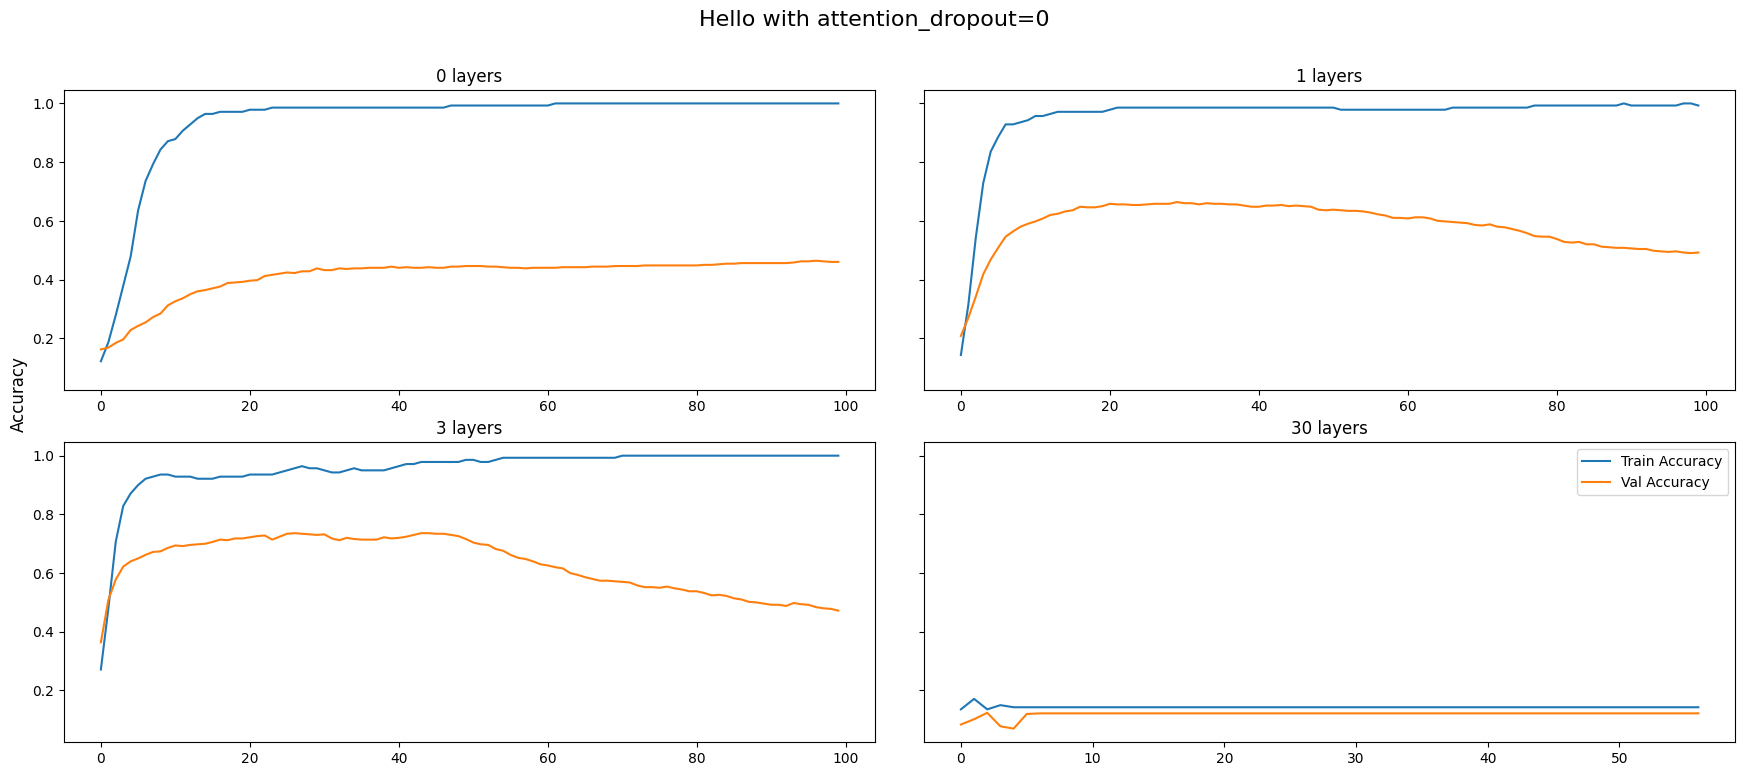

In [1295]:
# _, accuracies = experiment_train(attention_dropout=0, layer_count_list=[0,1,3,30], epochs=[100,100,100,500])
plot_experiment("Hello", accuracies)

  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.4659999907016754


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.4779999852180481


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.5180000066757202


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.6039999723434448


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 60
Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 50
Final validation accuracy: 0.12200000137090683


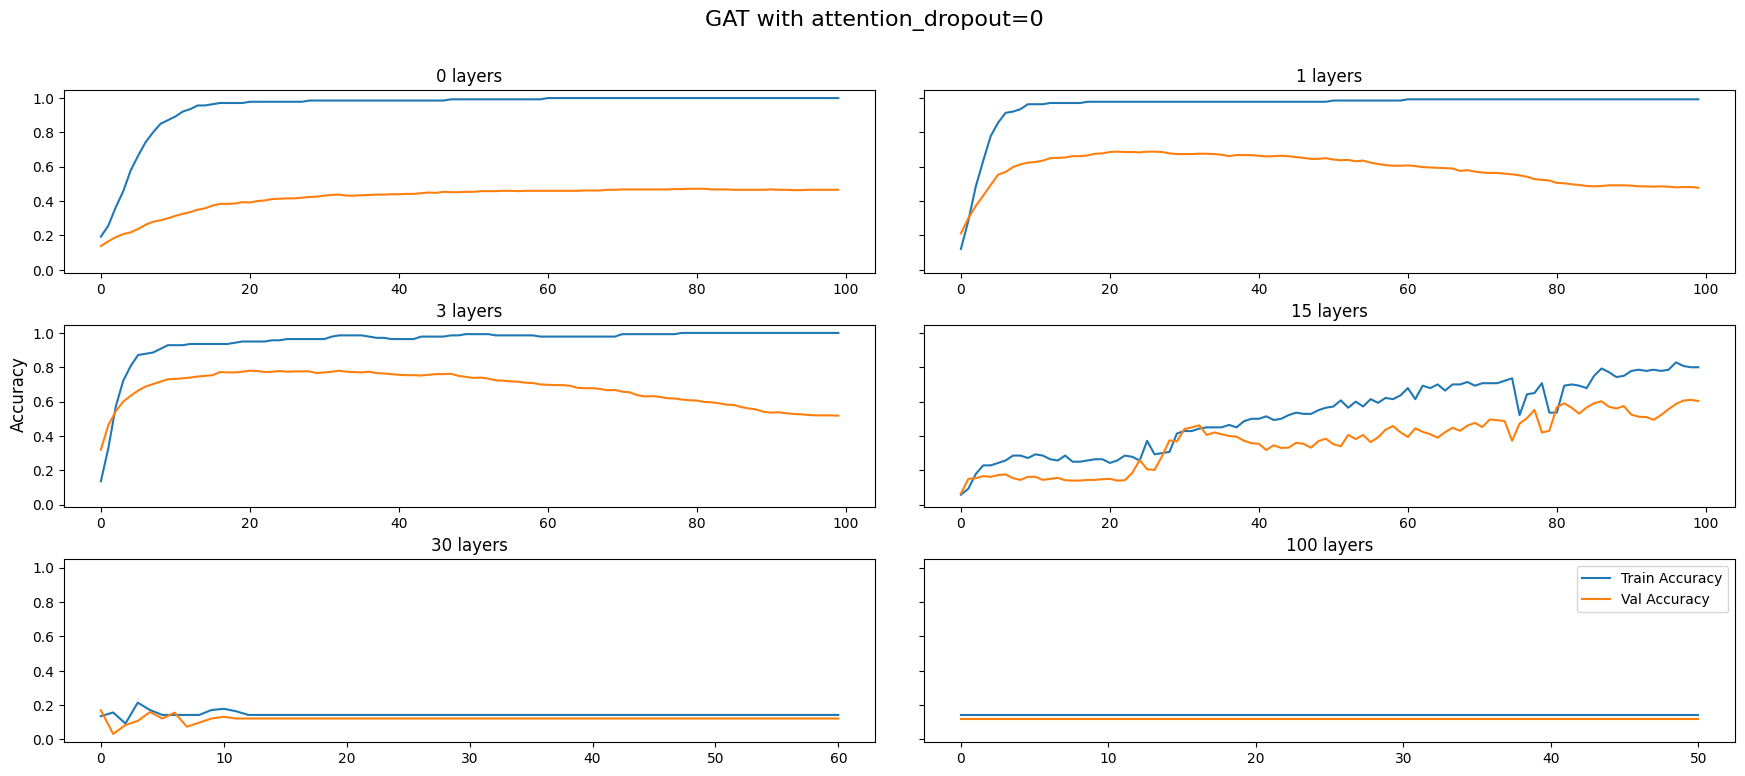

In [1292]:
run_experiment("GAT", attention_dropout=0)

  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.4740000069141388


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.5659999847412109


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.5460000038146973


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.34200000762939453


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3179999887943268


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2759999930858612


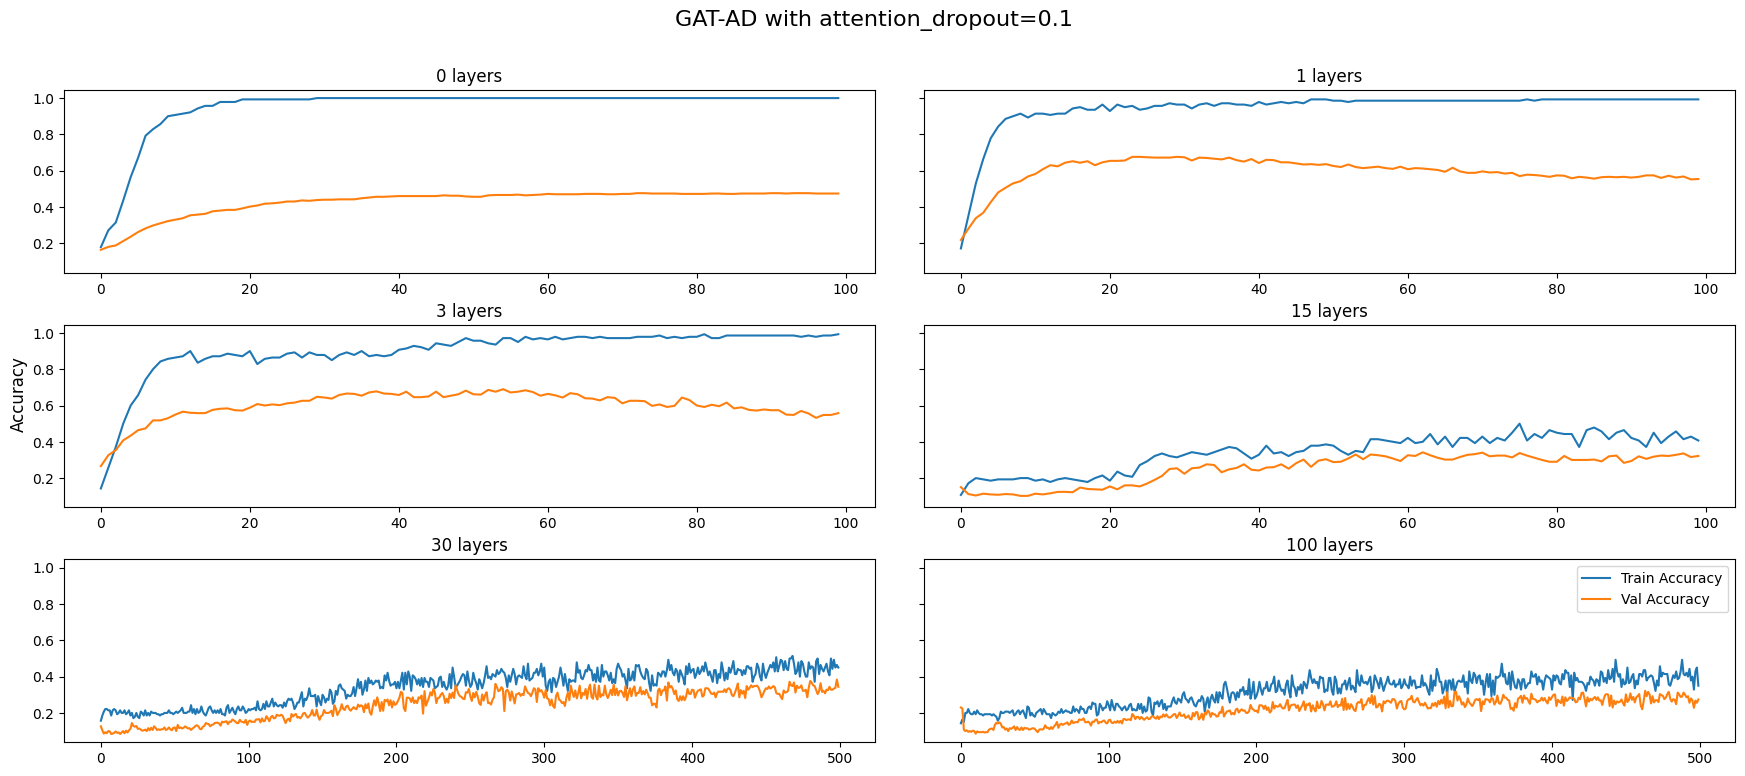

In [1296]:
run_experiment("GAT-AD", attention_dropout=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.4440000057220459


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.5180000066757202


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.5640000104904175


  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.22200000286102295


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2280000001192093


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.27000001072883606


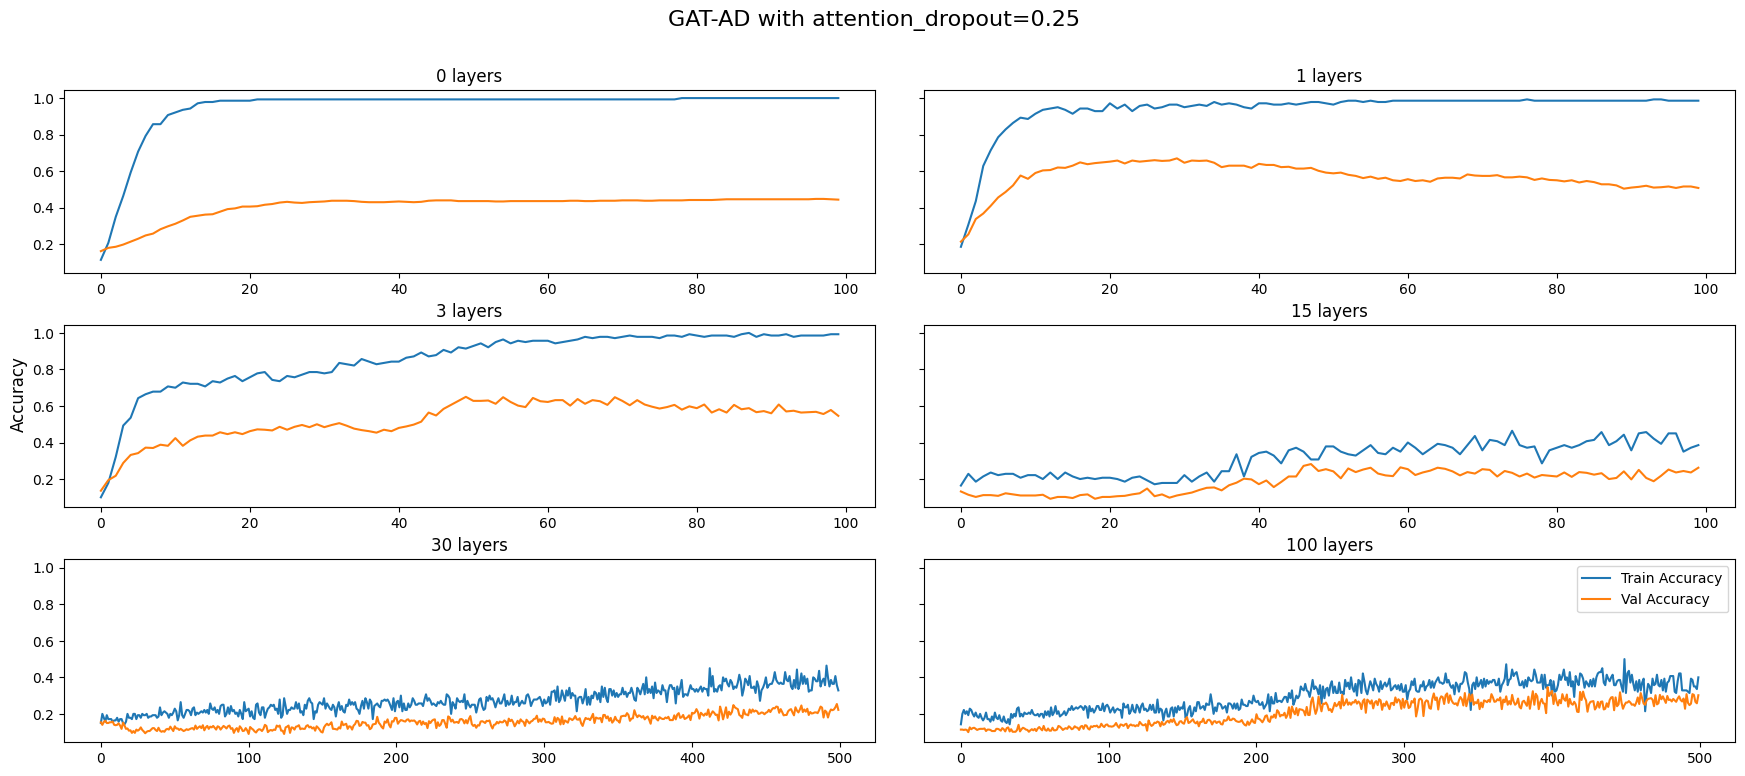

In [1297]:
run_experiment("GAT-AD", attention_dropout=0.25)

In [35]:
attn_drop_ratios = np.linspace(0,0.5,21)
attn_drop_accuracies_train = []
attn_drop_accuracies_val = []
accuracy_mean_range = 10
training_params["max_patience"] = 20

for att_drop in attn_drop_ratios:
    _, accuracies = experiment_train(attention_dropout=att_drop, layer_count_list=[15], epochs=[500])
    attn_drop_accuracies_train.append(np.mean(accuracies[0][1][0][-accuracy_mean_range:]))
    attn_drop_accuracies_val.append(np.mean(accuracies[0][1][1][-accuracy_mean_range:]))

  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4359999895095825


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3319999873638153


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.38600000739097595


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3479999899864197


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3319999873638153


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4259999990463257


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2840000092983246


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.31200000643730164


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3880000114440918


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2919999957084656


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2680000066757202


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2759999930858612


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.29600000381469727


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.25


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.23999999463558197


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.28200000524520874


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3100000023841858


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2680000066757202


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.35199999809265137


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3840000033378601


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.25200000405311584


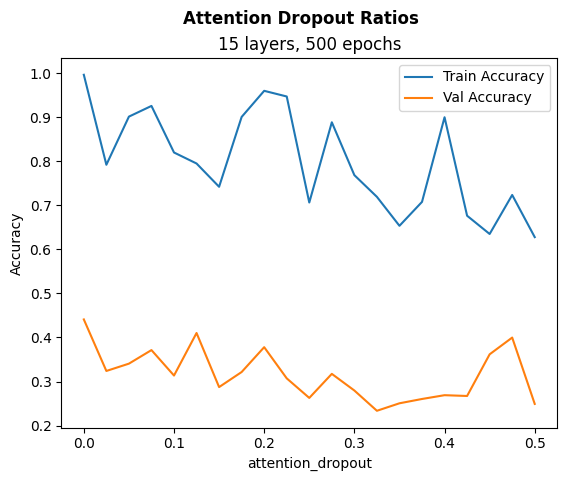

In [37]:
plt.suptitle("Attention Dropout Ratios",fontweight='bold')
plt.title("15 layers, 500 epochs")
plt.xlabel("attention_dropout")
plt.ylabel("Accuracy")

plt.plot(attn_drop_ratios, attn_drop_accuracies_train, label="Train Accuracy")
plt.plot(attn_drop_ratios, attn_drop_accuracies_val, label="Val Accuracy")
plt.legend()
plt.show()

In [32]:
attn_drop_ratios = np.linspace(0,0.5,21)
attn_drop_accuracies_train2 = []
attn_drop_accuracies_val2 = []
accuracy_mean_range = 10

for att_drop in attn_drop_ratios:
    _, accuracies = experiment_train(attention_dropout=att_drop, layer_count_list=[100], epochs=[500])
    attn_drop_accuracies_train2.append(np.mean(accuracies[0][1][0][-accuracy_mean_range:]))
    attn_drop_accuracies_val2.append(np.mean(accuracies[0][1][1][-accuracy_mean_range:]))

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 20
Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3479999899864197


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3199999928474426


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.33799999952316284


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3799999952316284


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.23600000143051147


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3540000021457672


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.28600001335144043


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.18199999630451202


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.21799999475479126


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2980000078678131


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2639999985694885


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.16599999368190765


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.20200000703334808


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.14800000190734863


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.17599999904632568


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15600000321865082


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.11400000005960464


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1080000028014183


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1379999965429306


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15800000727176666


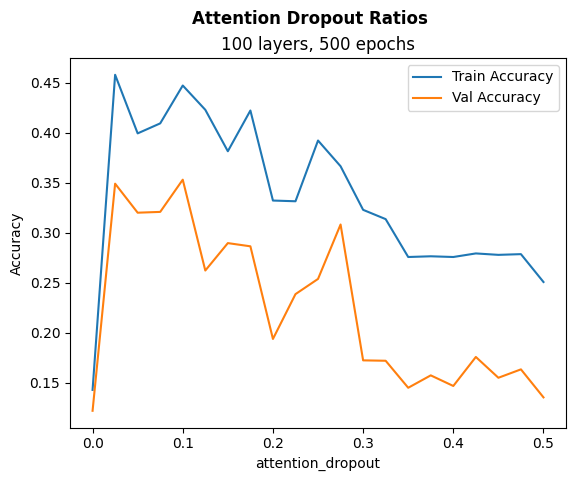

In [34]:
plt.suptitle("Attention Dropout Ratios",fontweight='bold')
plt.title("100 layers, 500 epochs")
plt.xlabel("attention_dropout")
plt.ylabel("Accuracy")

plt.plot(attn_drop_ratios, attn_drop_accuracies_train2, label="Train Accuracy")
plt.plot(attn_drop_ratios, attn_drop_accuracies_val2, label="Val Accuracy")
plt.legend()
plt.show()

In [38]:
layer_count_list = [0,1,3,15,30,100]
attn_drop_ratios = np.linspace(0,0.5,21)
attn_drop_accuracies_train = []
attn_drop_accuracies_val = []
accuracy_mean_range = 10
training_params["max_patience"] = 20

for layer_count in layer_count_list:
    tmp_train = []
    tmp_val = []
    for att_drop in attn_drop_ratios:
        _, accuracies = experiment_train(attention_dropout=att_drop, layer_count_list=[layer_count], epochs=[500])
        tmp_train.append(np.mean(accuracies[0][1][0][-accuracy_mean_range:]))
        tmp_val.append(np.mean(accuracies[0][1][1][-accuracy_mean_range:]))
    attn_drop_accuracies_train.append(tmp_train)
    attn_drop_accuracies_val.append(tmp_val)

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 256
Final validation accuracy: 0.43799999356269836


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 248
Final validation accuracy: 0.4580000042915344


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 164
Final validation accuracy: 0.45399999618530273


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 116
Final validation accuracy: 0.44600000977516174


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 102
Final validation accuracy: 0.43799999356269836


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 192
Final validation accuracy: 0.46000000834465027


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 233
Final validation accuracy: 0.4440000057220459


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 251
Final validation accuracy: 0.4480000138282776


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 256
Final validation accuracy: 0.44999998807907104


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 144
Final validation accuracy: 0.45399999618530273


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 139
Final validation accuracy: 0.4519999921321869


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 148
Final validation accuracy: 0.4560000002384186


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 133
Final validation accuracy: 0.44999998807907104


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 94
Final validation accuracy: 0.46399998664855957


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 131
Final validation accuracy: 0.4399999976158142


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 147
Final validation accuracy: 0.4560000002384186


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 280
Final validation accuracy: 0.43799999356269836


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 142
Final validation accuracy: 0.44999998807907104


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 139
Final validation accuracy: 0.4259999990463257


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 170
Final validation accuracy: 0.45399999618530273


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 258
Final validation accuracy: 0.44600000977516174


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 214
Final validation accuracy: 0.4779999852180481


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.46799999475479126


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.49799999594688416


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.41600000858306885


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4359999895095825


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.44200000166893005


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4300000071525574


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4620000123977661


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4819999933242798


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4440000057220459


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4480000138282776


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.414000004529953


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4580000042915344


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.46799999475479126


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4259999990463257


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.44999998807907104


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4580000042915344


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.41600000858306885


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4620000123977661


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3959999978542328


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 390
Final validation accuracy: 0.48399999737739563


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.36000001430511475


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.35600000619888306


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4059999883174896


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.49799999594688416


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.34200000762939453


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.44600000977516174


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.47999998927116394


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5220000147819519


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.46000000834465027


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.515999972820282


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4320000112056732


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3580000102519989


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4699999988079071


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.43799999356269836


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5019999742507935


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5220000147819519


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.49000000953674316


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.46399998664855957


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5440000295639038


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5600000023841858


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.5460000038146973


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.41200000047683716


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3580000102519989


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3319999873638153


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.40799999237060547


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3499999940395355


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.20999999344348907


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.25200000405311584


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3140000104904175


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2800000011920929


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.28600001335144043


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.30399999022483826


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.32199999690055847


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.44200000166893005


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.23600000143051147


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3619999885559082


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2879999876022339


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.21400000154972076


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2160000056028366


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.4399999976158142


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15199999511241913


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 30
Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.46399998664855957


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3619999885559082


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.28200000524520874


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2919999957084656


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.31200000643730164


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.27399998903274536


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.24799999594688416


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.335999995470047


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.32600000500679016


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3179999887943268


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1420000046491623


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.17599999904632568


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2879999876022339


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.19200000166893005


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.14800000190734863


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15399999916553497


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.164000004529953


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.14399999380111694


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1379999965429306


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopped training at epoch 20
Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3179999887943268


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2879999876022339


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3919999897480011


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.335999995470047


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.3179999887943268


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1979999989271164


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2240000069141388


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2840000092983246


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.2460000067949295


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.21799999475479126


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.25200000405311584


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15399999916553497


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1420000046491623


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.17000000178813934


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.18199999630451202


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.15600000321865082


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1720000058412552


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1599999964237213


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.12200000137090683


  0%|          | 0/500 [00:00<?, ?it/s]

Final validation accuracy: 0.1459999978542328


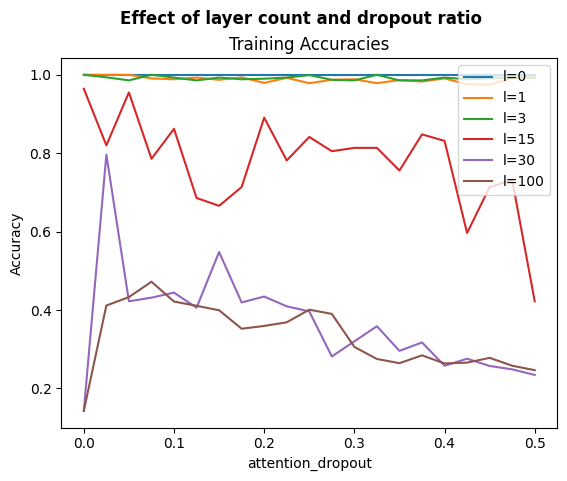

In [44]:
plt.suptitle("Effect of layer count and dropout ratio",fontweight='bold')
plt.title("Training Accuracies")
plt.xlabel("attention_dropout")
plt.ylabel("Accuracy")

for i,l in enumerate(attn_drop_accuracies_train):
    plt.plot(attn_drop_ratios, l, label=f"l={layer_count_list[i]}")
#     plt.plot(attn_drop_ratios, attn_drop_accuracies_val2, label="Val Accuracy")
plt.legend(loc='upper right')
plt.show()